In [1]:
# Importing Libraries

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [5]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [9]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\Ranjeet\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [10]:
X_test.shape

(2947, 128, 9)

In [11]:
def data():
    '''
    Data providing function:
    This function is separated from model() so that hyperopt
    won't reload data for each evaluation run.
    '''
    (X_train, y_train), (X_test, y_test) = load_data()
    X_train = X_train.reshape(7352, 128, 9)
    X_test = X_test.reshape(2947, 128, 9)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    nb_classes = 6
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    return X_train, Y_train, X_test, Y_test

In [12]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [13]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [14]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [34]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

ImportError: cannot import name 'BatchNormalization'

In [16]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [17]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [18]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


### (1) Model having 1 LSTM layer with 32 LSTM Units

In [62]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(32, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history = model.fit(X_train, Y_train, batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 32)                5376      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 51s 7ms/step - loss: 1.3230 - acc: 0.4313 - val_loss: 1.1829 - val_acc: 0.4581
Epoch 2/30
7352/7352 [==============================] - 47s 6ms/step - loss: 1.1046 - acc: 0.5026 - val_loss: 1.1248 - val_acc: 0.4971
Epoch 3/30
7352/7352 [==============================] - 48s 6ms/step - loss: 0.9713 - 

2947/2947 [==============================] - 2s 671us/step
Test Score: 0.508714
Test Accuracy: 89.005769%


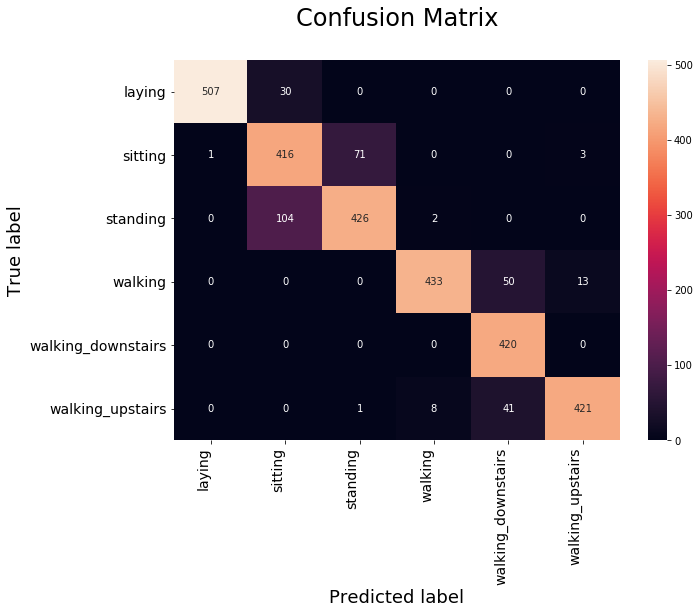

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=1)
print("Test Score: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

### (2) Model having 1 LSTM layer with 64 LSTM Units¶

In [64]:
# Initiliazing the sequential model
model1 = Sequential()
# Configuring the parameters
model1.add(LSTM(64, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model1.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model1.add(Dense(n_classes, activation='sigmoid'))
model1.summary()

# Compiling the model
model1.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history1 = model1.fit(X_train, Y_train, batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 64)                18944     
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 64s 9ms/step - loss: 1.2460 - acc: 0.4499 - val_loss: 1.1414 - val_acc: 0.5097
Epoch 2/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.9701 - acc: 0.5705 - val_loss: 0.9003 - val_acc: 0.5908
Epoch 3/30
7352/7352 [==============================] - 59s 8ms/step - loss: 0.8082 

2947/2947 [==============================] - 3s 908us/step
Test Score: 0.561873
Test Accuracy: 88.802172%


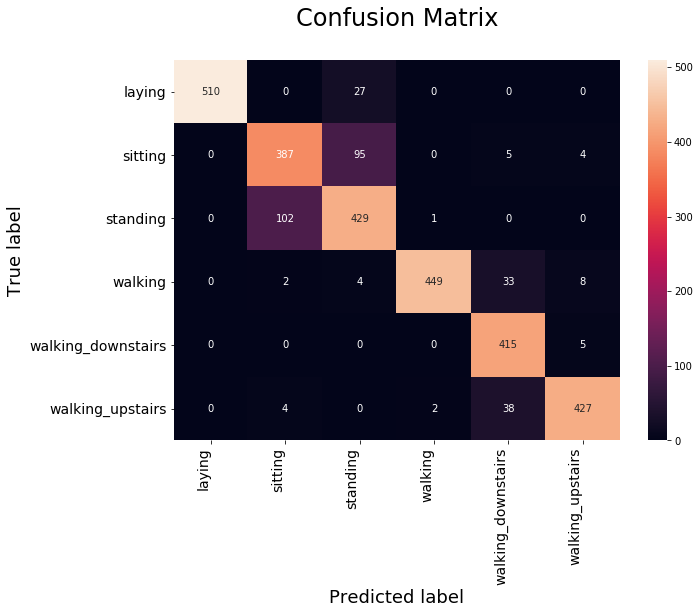

In [65]:
# Final evaluation of the model
scores1 = model1.evaluate(X_test, Y_test, verbose=1)
print("Test Score: %f" % (scores1[0]))
print("Test Accuracy: %f%%" % (scores1[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model1.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

### (3) Model having 1 LSTM layer with 128 LSTM Units¶

In [23]:
# Initiliazing the sequential model
model2 = Sequential()
# Configuring the parameters
model2.add(LSTM(128, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model2.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model2.add(Dense(n_classes, activation='sigmoid'))
print(model2.summary())

# Compiling the model
model2.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history2 = model2.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               70656     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 98s 13ms/step - loss: 1.2616 - acc: 0.4445 - val_loss: 1.1359 - val_acc: 0.5382
Epoch 2/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.9373 - acc: 0.5985 - val_loss: 0.9608 - val_acc: 0.5955
Epoch 3/30
7352/7352 [==============================] - 92s 13ms/step - loss:

Test Score: 0.503083
Test Accuracy: 88.802172%


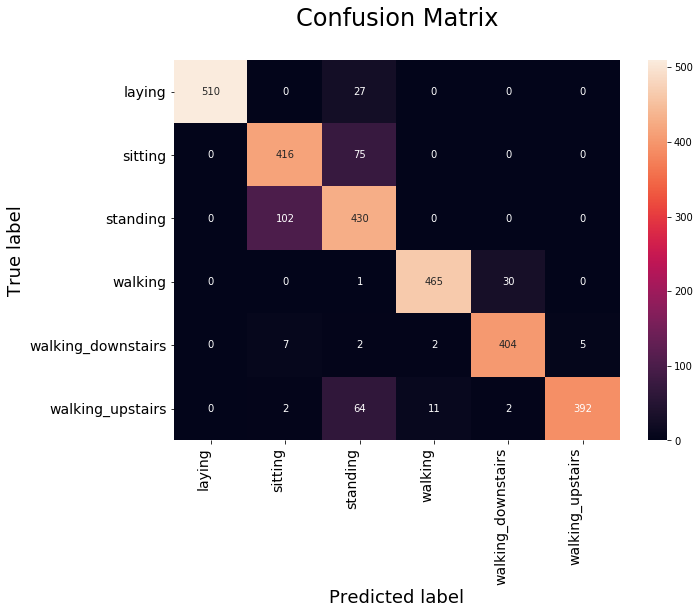

In [24]:

# Final evaluation of the model
scores2 = model2.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores2[0]))
print("Test Accuracy: %f%%" % (scores2[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model2.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

### (4) Model having 2 LSTM layer with 32 LSTM Units¶

In [25]:
# Initiliazing the sequential model
model3 = Sequential()
# Configuring the parameters
model3.add(LSTM(32,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model3.add(Dropout(0.5))

# Configuring the parameters
model3.add(LSTM(32))
# Adding a dropout layer
model3.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model3.add(Dense(n_classes, activation='sigmoid'))
print(model3.summary())

# Compiling the model
model3.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history3 = model3.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 107s 15ms/step - loss: 1.2150

Test Score: 0.454262
Test Accuracy: 89.446895%


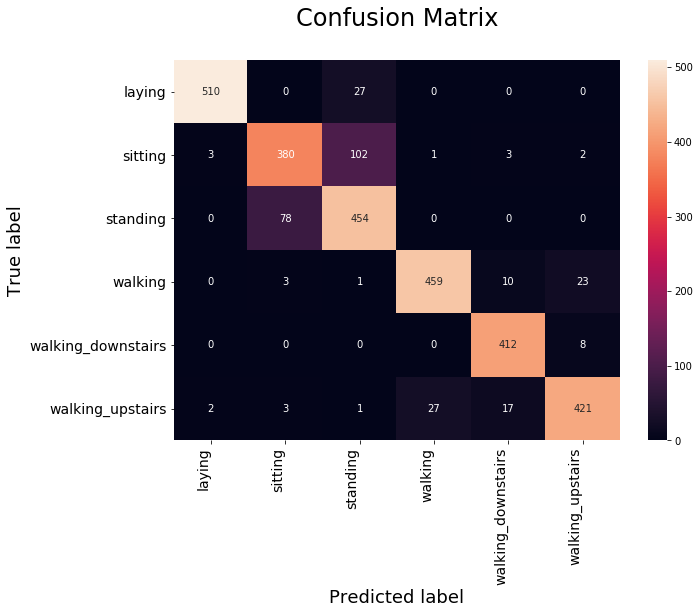

In [26]:
# Final evaluation of the model
scores3 = model3.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores3[0]))
print("Test Accuracy: %f%%" % (scores3[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model3.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

#### (5) Model having 2 LSTM layer with 64 LSTM Units¶

In [27]:
model4= Sequential()
# Configuring the parameters
model4.add(LSTM(64,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model4.add(Dropout(0.7))

# Configuring the parameters
model4.add(LSTM(64))
# Adding a dropout layer
model4.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model4.add(Dense(n_classes, activation='sigmoid'))
print(model4.summary())

# Compiling the model
model4.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history4= model4.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 142s 19ms/step - loss: 1.1618

Test Score: 0.656322
Test Accuracy: 89.650492%


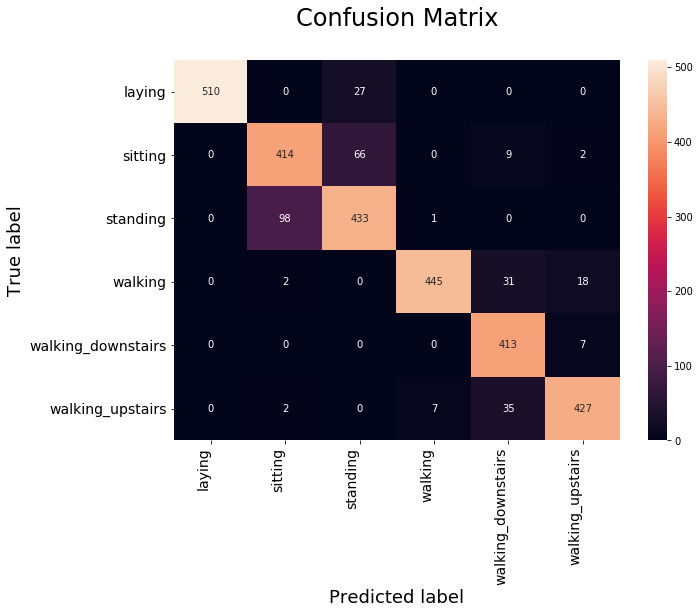

In [28]:
# Final evaluation of the model
scores4 = model4.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores4[0]))
print("Test Accuracy: %f%%" % (scores4[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model4.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

### (6) Model having 2 LSTM layer with 128 LSTM Units¶

In [29]:
model5= Sequential()
# Configuring the parameters
model5.add(LSTM(64,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model4.add(Dropout(0.7))

# Configuring the parameters
model5.add(LSTM(64))
# Adding a dropout layer
model5.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model5.add(Dense(n_classes, activation='sigmoid'))
print(model5.summary())

# Compiling the model
model5.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history5= model5.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 148s 20ms/step - loss: 1.1115 - acc: 0.5272 - val_loss: 0.9108 - val_acc: 0.6400
Epoch 2/30
7352/7352 [==============================] - 157s 21ms/step - loss: 0

Test Score: 0.393826
Test Accuracy: 91.245334%


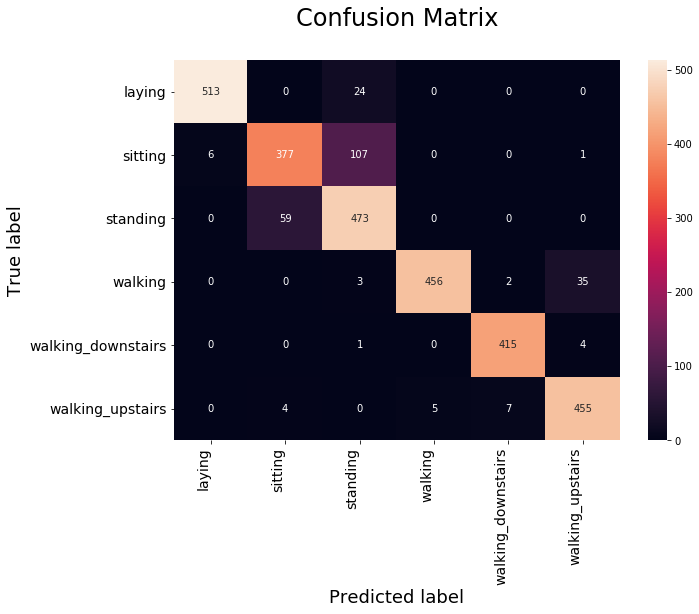

In [30]:
# Final evaluation of the model
scores5 = model5.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores5[0]))
print("Test Accuracy: %f%%" % (scores5[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model5.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

### (7) Model with 1 LSTM Layer having 128 LSTM units + Batch Normalization

In [40]:
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
model6 = Sequential() # Initiliazing the sequential model3
model6.add(LSTM(128, input_shape=(timesteps, input_dim))) # Configuring the parameters
model6.add(BatchNormalization())
model6.add(Dropout(0.40)) # Adding a dropout layer
model6.add(Dense(n_classes, activation='sigmoid')) # Adding a dense output layer with sigmoid activation
model6.summary()

optim=RMSprop(epsilon=0.00001, decay=1e-6, clipnorm =1)
model6.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy']) # Compiling the model

# Training the model
history6= model6.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 128)               70656     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 774       
Total params: 71,942
Trainable params: 71,686
Non-trainable params: 256
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 89s 12ms/step - loss: 0.9934 - acc: 0.5604 - val_loss: 0.8194 - val_acc: 0.5894
Epoch 2/30
7352/7352 [==============================] - 83s 11ms/step - loss: 0.7753

Test Score: 0.454131
Test Accuracy: 91.482864%


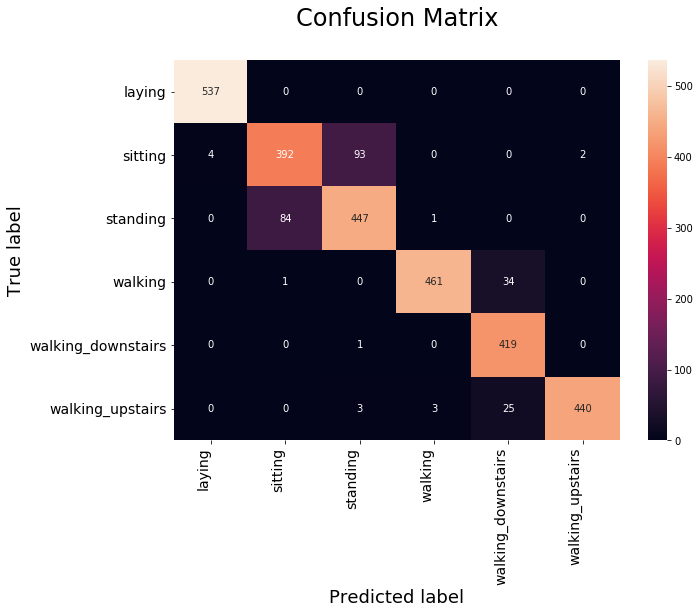

In [60]:
# Final evaluation of the model
scores6 = model6.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores6[0]))
print("Test Accuracy: %f%%" % (scores6[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model6.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

## CONCLUSION

In [66]:

# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names =['1 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop)','1 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop)',\
        '1 LSTM layer with 128 LSTM Units(Optimizer-->rmsprop)','2 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop)',\
        '2 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop)','2 LSTM layer with 128 LSTM Units(Optimizer-->rmsprop)',\
       ' 1 LSTM layer with 128 LSTM Units(Optimizer-->rmsprop)+BatchNorm']

# Training accuracies
train_acc = [history.history['acc'][10],history.history['acc'][29],history2.history['acc'][29],\
             history3.history['acc'][29],history4.history['acc'][29],history5.history['acc'][29],history6.history['acc'][29]]

# Test accuracies
test_acc =[scores[1],scores1[1],scores2[1],scores3[1],scores4[1],scores5[1],scores6[1]]

numbering = [1,2,3,4,5,6,7]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+------------------------------------------------------------------+--------------------+--------------------+
| S.NO. |                              MODEL                               | Training Accuracy  |   Test Accuracy    |
+-------+------------------------------------------------------------------+--------------------+--------------------+
|   1   |       1 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop)       | 0.7729869423286181 | 0.8900576857821514 |
|   2   |       1 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop)       | 0.9460010881392819 | 0.8880217170003394 |
|   3   |      1 LSTM layer with 128 LSTM Units(Optimizer-->rmsprop)       | 0.9526659412404788 | 0.8880217170205649 |
|   4   |       2 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop)       | 0.9521218715995647 | 0.8944689514760774 |
|   5   |       2 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop)       | 0.9525299238302503 | 0.8965049202578894 |
|   6   |      2 LSTM layer with 128 LSTM Units(

#### <b> Sl. no 6 and 7 are giving a accuracy of almost 91.5%